# [NTDS'18] milestone 2: network models
[ntds'18]: https://github.com/mdeff/ntds_2018

[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `8`
* Students: `Matyas Lustig, Aurélien Pomini, David Salathé, Justine Weber`
* Dataset: `Flight Routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* In the first part, you cannot import any other library than we imported. In the second part, you are allowed to import any library you want.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The purpose of this milestone is to explore various random network models, analyse their properties and compare them to your network. In the first part of the milestone you will implement two random graph models and try to fit them to your network. In this part you are not allowed to use any additional package. In the second part of the milestone you will choose a third random graph model that you think shares some properties with your network. You will be allowed to use additional packages to construct this network, but you must explain your network choice. Finally, make your code as clean as possible, and keep your textual answers short.

## Part 0

Import the adjacency matrix of your graph that you constructed in milestone 1, as well as the number of nodes and edges of your network.

In [20]:
import numpy as np

adjacency =  np.load('data/adjacency_sym_mtx_uw.npy')  # the adjacency matrix
n_nodes =  adjacency.shape[0] # the number of nodes in the network
adjacency[np.diag_indices_from(adjacency)] = 0 # set diagonal elements to 0 (see comment)
n_edges =  adjacency.sum() / 2 # the number of edges in the network

In [21]:
print("Number of nodes : ", n_nodes)
print("Number of edges : ", n_edges)

Number of nodes :  3179
Number of edges :  18616.0


**Comment 1:** <br>
We have decided to import the symmetric unweighted adjacency matrix, previously computed in Milestone one. Why symmetric and unweighted ? <br>
Because in this milestone (2), we will compare our network to random network models. From the models we have seen in class, the random network models we will use and built by adding edges which are undirected and unweighted. Therefore we have concluded that it would make more sense to compare a network sharing the same properties, ie. the unweighted symmetric version of our network.

**Comment 2:** <br>
We have noticed that our previously constructed graph from Milestone 1, actually has self loop. It comes from the fact that, in the routes data set, one entry related an airport to itself : it is both the source and the destination airport of the entry (it is the airport having IATA "PKN", and the entry at index 33276 in routes). As a consequence, our adjacency matrix has one non zero element on the diagonal. <br>
If we place this in the context of airlines, it doesn't really make sense to have a line from an airport to itself. We have therefore decided to ignore this edge in the adjacency matrix. This is why we compute the number of edges by summing the elements of the unweighted adjacency matrix and subtracting one. We divide by two since the matrix is symmetric : each path is represented twice for each direction.

## Part 1

**For the computation of this part of the milestone you are only allowed to use the packages that have been imported in the cell below.**

In [22]:
%matplotlib inline

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from scipy.sparse import random

### Question 1

Create a function that constructs an Erdős–Rényi graph.

In [23]:
def erdos_renyi(n, p, seed=None):
    """Create an instance from the Erdos-Renyi graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    p: float
        Edge probability. A number between 0 and 1.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    np.random.seed(seed)

    rnd = np.random.choice([0, 1], size=(n, n), p=[1-p, p])
    rnd = np.triu(rnd, 1)
    adjacency = rnd + rnd.T

    return adjacency

0.32


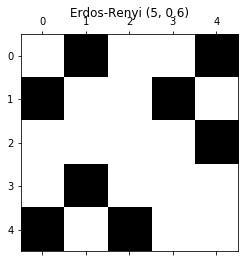

In [24]:
er = erdos_renyi(5, 0.6, 9765) #9765
plt.spy(er)
plt.title('Erdos-Renyi (5, 0.6)')

print(er.sum() / (5*5))

Text(0.5, 1.05, 'Erdos-Renyi (10, 0.4)')

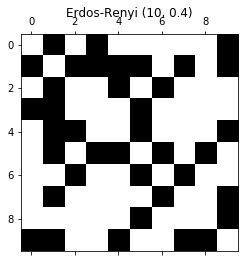

In [25]:
er = erdos_renyi(10, 0.4, 7648)
plt.spy(er)
plt.title('Erdos-Renyi (10, 0.4)')

### Question 2

Use the function to create a random Erdos-Renyi graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

In [26]:
p = 2 * n_edges / ( n_nodes * (n_nodes-1) )
er = erdos_renyi(n_nodes, p, None)
print('Our graph no. of edges:', n_edges)
print('ER graph no. of edges:', er.sum() / 2)

Our graph no. of edges: 18616.0
ER graph no. of edges: 18651.0


**Answer :** <br>
We compute the probability of having an edge in the ER model by deviding the number of edges in our graph by the maximum number of edges for the given number of nodes in our graph.

### Question 3

Create a function that constructs a Barabási-Albert graph.

In [27]:
def barabasi_albert(n, m, seed=None):
    """Create an instance from the Barabasi-Albert graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    m: int
        Number of edges to attach from a new node to existing nodes.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    assert n >= m, "m cannot be bigger than n"
    
    # Set the seed
    np.random.seed(seed)
    
    # Create adjacency matrix for BA-model
    adjacency = np.zeros((n,n))
    
    # List of nodes to connect 
    candidates = set(np.arange(n))
    
    # t is number of iterations
    t = n - m
    
    # Initiation of the graph :
    # Connect m randomly selected initial nodes 
    # among the n, as a line in a random order
    m0s = np.random.choice(n, m, replace=False)
    for i in range(m0s.shape[0]-1):
        adjacency[m0s[i], m0s[i+1]] = 1
        adjacency[m0s[i+1], m0s[i]] = 1
        
    candidates -= set(m0s)

    # Add new nodes for t iterations
    for i in range(t):
        totalDeg = adjacency.sum()
        if totalDeg == 0:
            prefs = np.zeros((n))
            prefs[m0s[0]] = 1
        else:
            # table of proba for preferential attachement
            prefs = [x.sum()/totalDeg for x in adjacency]
        
        # Select m neighbours randomly according to preferential 
        # attachement to connect the new node to 
        # the nodes which aren't in the graph yet have probability 0
        ms = np.random.choice(n, m, replace=False, p=prefs)
        
        # Select the new node to connect randomly
        candidate = np.random.choice(list(candidates), 1, replace=False)
        
        # Add the m new edges in adjacency matrix
        for j in range(ms.shape[0]):
            adjacency[candidate, ms[j]] = 1
            adjacency[ms[j], candidate] = 1
        
        candidates -= set(candidate)
        
    assert len(candidates) == 0
        
    return adjacency

Text(0.5, 1.05, 'Barabasi-Albert (5, 1)')

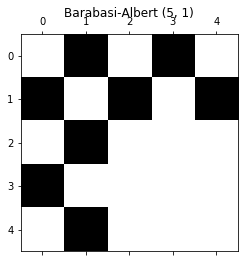

In [28]:
ba = barabasi_albert(5, 1, 9087)
plt.spy(ba)
plt.title('Barabasi-Albert (5, 1)')

Text(0.5, 1.05, 'Barabasi-Albert (10, 2)')

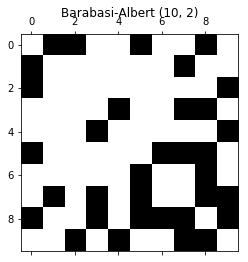

In [29]:
ba = barabasi_albert(10, 2, 8708)
plt.spy(ba)
plt.title('Barabasi-Albert (10, 2)')

### Question 4

Use the function to create a random Barabási-Albert graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

Root 1: 5.86490475086066
Root 2: 3174.1350952491393
19043.0


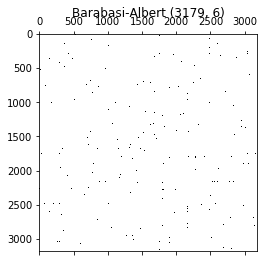

In [30]:
root1 = (-(n_nodes + 1) + np.sqrt((n_nodes + 1)**2 - 4 * n_edges))/(-2)
root2 = (-(n_nodes + 1) - np.sqrt((n_nodes + 1)**2 - 4 * n_edges))/(-2)
print("Root 1:", root1)
print("Root 2:", root2)
m = int(round(root1))
ba = barabasi_albert(n_nodes, m)
plt.spy(ba)
plt.title('Barabasi-Albert ({}, {})'.format(n_nodes, m))
print(ba.sum()//2)

**Comments :** <br>
The parameter n is trivial: n_nodes. <br>
For the parameter m, recall that if we fix $m_0 = m$, we have $mt + m_0$ edges, ie. $mt + m$ edges. <br>
We also have $t = N - m$. <br>
This yield $n\_edges = mt + m = m(N - m) + m = mN - m^2 + m = m(N+1) - m^2$. <br>
Then by solving the equation, we have $-m^2 + (n\_nodes+1)m - n\_edges = 0$, where N = n_nodes. <br>
Roots are 5.86 and 3174.13. <br>
However, the minimal degree of each new node in the BA algorithm is clearly near 5.86 than 3174.13, which we can verify by looking at the degree distribution of our network. We therefore decided to choose round(5.86) => 6.

### Question 5

Compare the number of edges in all three networks (your real network, the Erdős–Rényi network, and the Barabási-Albert netowk).

In [31]:
print("Number of edges Erdos-Reni :", er.sum() / 2)
print("Number of edges B-A:", ba.sum() / 2)
print("Number of edges in our network:", n_edges)

Number of edges Erdos-Reni : 18651.0
Number of edges B-A: 19043.0
Number of edges in our network: 18616.0


**Comments:**<br>
Since the number of edges for ER algorithm is random, we don't always have exactly the same number of edges, but on average the number of edges is similar between ER graph and our network (~ +- 400 edges, ie. ~ +-2%). <br>
For BA algorithm, the number of edges is deterministic, and the randomness comes from which nodes to connect together. The best approximation of the number of edges we get is 19043 (with $m=6$). This corresponds to 2% precision error.

### Question 6

Implement a function that computes the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between two probability distributions.
We'll use it to compare the degree distributions of networks.

In [32]:
def kl_divergence(p, q, log=False, first_interval_width=1, exponent=1.1, bins=None):
    """Compute the KL divergence between probability distributions of degrees of two networks.
    
    Parameters
    ----------
    p: np.array
        Probability distribution of degrees of the 1st graph.
    q: np.array
        Probability distribution of degrees of the 2nd graph.
    
    Returns
    -------
    kl
        The KL divergence between the two distributions.
    """
    
    # log scale
    size = min(len(p), len(q))
    if bins==None:
        bins=size
    
    if(log):
        new_p = []
        new_q = []
        start = 0
        width = first_interval_width

        
        while(start + width < size):
            
            end = start+width           
            width = int(np.ceil(width*exponent))
            
            if (size-end < width):
            
                end = size

            for new_distr, distr in zip((new_p, new_q), (p, q)):
                new_distr.append(distr[start:end].sum())
                       
            start = end
        
        for new in new_p, new_q:
            new = np.array(new)
    
    # linear bins       
    else:
        interval_length = size // bins
          
        new_p = np.zeros(bins)
        new_q = np.zeros(bins)      
        
        start = 0
        for i in range(bins):
            
            end = start + interval_length
            if i == bins-1:
                end = size
            
            for new_distr, distr in zip((new_p, new_q), (p, q)):
                new_distr[i] = distr[start:end].sum()
            start = end
            
    # compute Dkl(P||Q)
    # pi ln (pi / qi)
    # (p * np.log(p/q)).sum()
    def helper_kl(p,q):
        if p == 0.0 or q == 0.0:
            return 0.0
        return p * np.log(p/q)
    
    if bins==None:
        new_p = p
        new_q = q
        
    return np.vectorize(helper_kl)(new_p,new_q).sum()

In [33]:
p_test = np.array([0.2, 0.2, 0.2, 0.4])
q_test = np.array([0.3, 0.3, 0.1, 0.3])
kl_divergence(p_test, q_test)

0.09151622184943575

### Question 7

Compare the degree distribution of your network to each of the two synthetic ones, in terms of KL divergence. **Hint:** Make sure you normalise your degree distributions to make them valid probability distributions.

In [34]:
def make_distrib(histogram):
    max_ = np.max(histogram) +1
    histogram = histogram.astype(int)
    result = np.zeros(int(max_))
    for deg in histogram :
        result[deg] +=1
        
    # normalization   
    return result/np.sum(result)

In [35]:
def make_histogram(adjacency):
    degree = np.sum(adjacency, axis = 0)
    total = degree.sum()
    return degree / total, degree

In [36]:
our_freq_histo, our_histo = make_histogram(adjacency)

ba_freq_histo, ba_histo = make_histogram(ba)

er_freq_histo, er_histo = make_histogram(er)

In [37]:
our_dist = make_distrib(our_histo)
ba_dist = make_distrib(ba_histo)
er_dist = make_distrib(er_histo)

compare_BA = kl_divergence(our_dist, ba_dist, bins = 19)
compare_ER = kl_divergence(our_dist, er_dist, bins = 19)
print("BA vs our network KL-Divergence :",compare_BA)
print("ER vs our network KL-Divergence :", compare_ER)

BA vs our network KL-Divergence : 0.09803923589489685
ER vs our network KL-Divergence : 1.9501778591350312


### Question 8

Plot the degree distribution historgrams for all three networks. Are they consistent with the KL divergence results? Explain.

Text(0.5, 1.0, 'Compare histograms of ER, BA, our network')

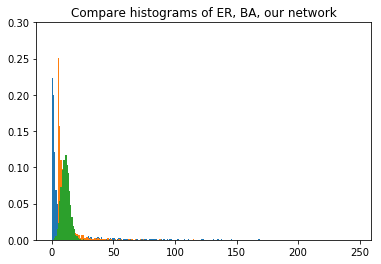

In [38]:
weights = np.ones_like(our_histo) / float(n_nodes)
max_ = len(our_dist)
b1 = np.linspace(0, max_, max_)
plt.hist(our_histo, weights=weights, bins=b1)
plt.hist(ba_histo, weights=weights, bins=b1)
plt.hist(er_histo, weights=weights, bins=b1)
plt.ylim((0, 0.3))
plt.title("Compare histograms of ER, BA, our network")

Text(0.5, 1.0, 'Compare histograms of ER, BA, our network')

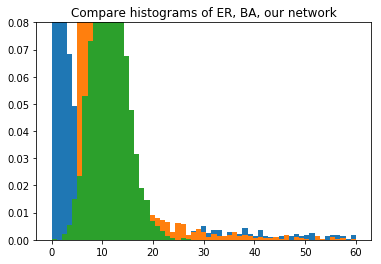

In [39]:
# Second plot to see more details
b2 = np.linspace(0, 60, 60)
plt.hist(our_histo, weights=weights, bins=b2)
plt.hist(ba_histo, weights=weights, bins=b2)
plt.hist(er_histo, weights=weights, bins=b2)
plt.ylim((0, 0.08))
plt.title("Compare histograms of ER, BA, our network")

Blue: Real Network. <br/>
Orange: Albert <br/>
Green: random <br/>

Text(0.5, 1.0, 'Degree distribution of our network')

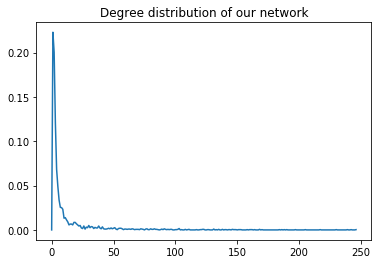

In [40]:
plt.plot(our_dist)
plt.title("Degree distribution of our network")

Text(0.5, 1.0, 'Degree distribution of the barabasi-albert model')

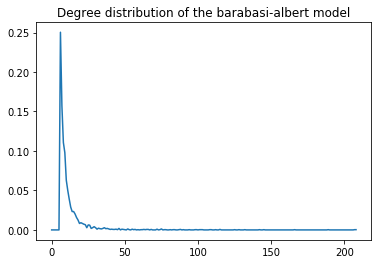

In [41]:
plt.plot(ba_dist)
plt.title("Degree distribution of the barabasi-albert model")

Text(0.5, 1.0, 'Degree distribution of the erdos-reny model')

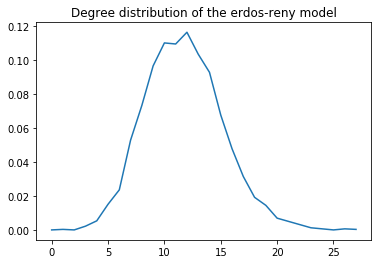

In [42]:
plt.plot(er_dist)
plt.title("Degree distribution of the erdos-reny model")

**Answers:**<br>
The histogram is consistent with the KL results. In fact, we can see from the different plots that the shape of the degree distribution of the BA-graph and our graph are very similar : low degrees are very much represented (between 0 and 5 for our network and between 5 and 10 for BA), and there are still some nodes with very high degree (until 247 !). We also observe that our real network has a very high decrease, which looks like a power-law distribution. This confirms that BA and our network have a close degree distribution, since we know BA follows a power-law distribution. On the other hand, the degree distribution of the ER graph has a very different shape : it has a shape of a binomial distribution, centered arround 10 or 11, and spread until 0 and 25. Higher degree are not represented at all in the ER graph (probability zero from degree 26). <br>
This is consistent with the results we got in the previous question : the KL divergence for BA was lower which means that its degree distribution closer to our network. <br> <br>
We also see from these graphs that the graph that would correspond to ours would have the same degree dsitribution as BA, but shifted to the left, ie. with lower degrees.

### Question 9

Imagine you got equal degree distributions. Would that guarantee you got the same graph? Explain.

**Answer :** <br>
No. As a counter example, we can compare these two different adjacency matrices: <br>
 >[[0, 1, 1, 0, 0, 0], <br>
 [1, 0, 1, 0, 0, 0], <br>
 [1, 1, 0, 0, 0, 0], <br>
 [0, 0, 0, 0, 1, 1], <br>
 [0, 0, 0, 1, 0, 1], <br>
 [0, 0, 0, 1, 1, 0]] <br>
 <br>
 [[0, 1, 0, 0, 0, 1], <br>
 [1, 0, 1, 0, 0, 0], <br>
 [0, 1, 0, 1, 0, 0], <br>
 [0, 0, 1, 0, 1, 0], <br>
 [0, 0, 0, 1, 0, 1], <br>
 [1, 0, 0, 0, 1, 0]] <br>
 
where the first one represents two disconected triangles and the second one an hexagone. Both of these graphs has the same degree distribution: 6 nodes of degree 2. But they are extremely different, one is disjoint, the other not.

## Part 2

**You are allowed to use any additional library here (e.g., NetworkX, PyGSP, etc.).** Be careful not to include something here and use it in part 1!

In [43]:
import networkx as nx

### Question 10

Choose a random network model that fits you network well. Explain your choice. 

**Hint:** Check lecture notes for different network models and their properties. Your choice should be made based on at least one property you'd expect to be similar.

**Answer:**<br>
After having tested different possible models, we still think Barabasi-Albert is the closest known model to our network in terms of degree distribution. We can see it from the shape of the distributions showed before. To make it even closer to our network, we could improve it by tweaking some variable such as the shape of the initial graph. <br> 
However for the purpose of the milestone, we will present another model which is : Kim and Holme model. <br>
We have chosen this one for the properties of having some nodes with high degree (hubs) and possibility of influencing the clustering coefficient. It is implemented in networkX library by function powerlaw_cluster_graph.

We have also tried implementing Watts-Strogatz algorithm, but its degree distribution was very different from ours. It was better than Erdos-Reny, with a KL_divergence of 0.24, but way worse than BA or Kim-Holme (~0.05).

### Question 11

Explain (in short) how the chosen model works.

This model works very similar to the Barabasi-Albert model. It takes one more parameter $p$, which is the probability of adding randomly extra edges to generate a triangle at each step.

### Question 12

Create a random graph from that model, such that the number of nodes is the same as in your graph.

0.05476958985948191


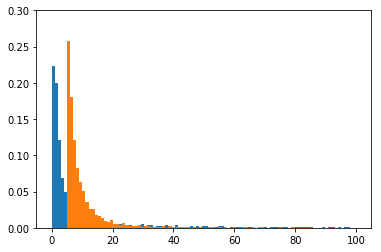

In [44]:
m = 6
p = 0.4
seed = 2

# kim-holme
kim_holme = nx.powerlaw_cluster_graph(n_nodes, m, p, seed=3)
kh_adj = np.array(nx.to_numpy_matrix(kim_holme))
kh_freq_histo, kh_histo = make_histogram(kh_adj)
kh_dist = make_distrib(kh_adj)

# watts-strogatz (we won't use it)
ws = nx.connected_watts_strogatz_graph(n_nodes, 5, 0.9, seed=3)
ws_adj = np.array(nx.to_numpy_matrix(ws))
ws_freq_histo, ws_histo = make_histogram(ws_adj)
ws_dist = make_distrib(ws_adj)

weights = np.ones_like(our_histo) / float(n_nodes)
b = np.linspace(0, 100, 100)
plt.hist(our_histo, weights=weights, bins=b)
plt.hist(kh_histo, weights=weights, bins=b)
plt.ylim((0, 0.3))

kh_dist = make_distrib(kh_histo)
kl = kl_divergence(kh_dist, our_dist, bins = 19)
print(kl)

### Question 13

Check the properties you expected to be similar, and compare to your network.

Kim-Holme
Number of nodes ( real ):  3179
Number of nodes ( random ):  3179
Number of edges ( real ):  18616
Number of edges ( random ):  19011
clustering coefficient ( real ):  0.4905417456798235
clustering coefficient ( random ):  0.13984017795921191
Average degree ( real ):  11.711859075180875
Average degree ( random ):  11.96036489462095
Average neighbor degree ( real ): 


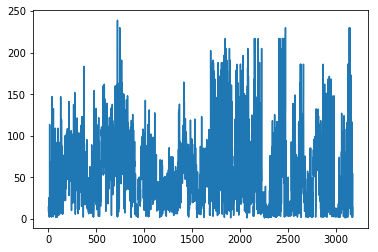

Average neighbor degree ( random ): 


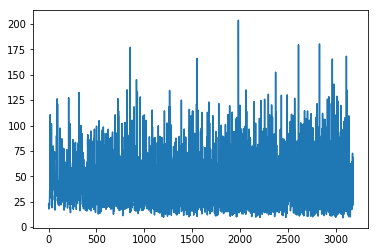

K nearest neighbors ( real ): 


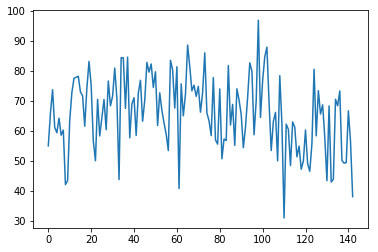

K nearest neighbors ( random ): 


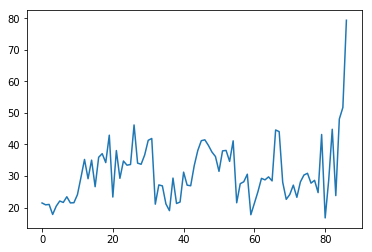

Degree distribution ( real ): 
(1, 3179)
Degree distribution ( random ): 
(1, 3179)

Properties of the largest component ( real ): 
Nodes, edges:  3154  ,  18616
Clustering coef:  0.49144436995862156
Avg degree:  11.789473684210526

Properties of the largest component ( random ): 
Nodes, edges:  3179  ,  19011
Clustering coef:  0.13984017795921191
Avg degree:  11.96036489462095

 Real Graph: 
 Random Graph: 
KL divergence between them:  0.05476958985948191


In [45]:
#Degree distribution, clusturing coefficient, diameter, (average degree), compare biggest component, hubs?
def compare(real, random):

    graphs = (real, random)
    def name(G):
        return 'real' if G == real else 'random'
    
    
    print("=================")  
    [print("Number of nodes (", name(G) ,"): ", nx.number_of_nodes(G)) for G in graphs]
    
    print("=================")  
    [print("Number of edges (", name(G) ,"): ", nx.number_of_edges(G)) for G in graphs]
    
    print("=================")  
    [print("clustering coefficient (", name(G) ,"): ", nx.average_clustering(G)) for G in graphs]
    print("=================")  
    [print("Average degree (", name(G) ,"): ", np.array([d for n, d in G.degree()]).mean()) for G in graphs]
        
    
    for G in graphs:
        avg_deg_connectivity = nx.average_degree_connectivity(G)
    #print("Average degree connectivity: ", nx.average_degree_connectivity(G))
        
    
    for G in graphs:
        print("Average neighbor degree (", name(G) ,"): ")
        average_neighbor_degree = nx.average_neighbor_degree(G)
    
        plt.figure()
        plt.plot(average_neighbor_degree.values())
        plt.show()
    
    for G in graphs:
        k_nearest = nx.k_nearest_neighbors(G)
        print("K nearest neighbors (", name(G) ,"): ")
    
    
        plt.figure()
        plt.plot(k_nearest.values())
        plt.show()
        
        
    for G in graphs:
        adj = nx.to_numpy_matrix(G)
        
        distr, _ = make_histogram(adj)
        print("Degree distribution (", name(G) ,"): ")
    
        print(distr.shape)
        distr, _ = make_histogram(adj)
    
    
        
    Gc = max(nx.connected_component_subgraphs(G), key=len)
      
        

    for G in graphs:
        print()
        print("=====================================")
        print("Properties of the largest component (", name(G) ,"): ")
        Gc = max(nx.connected_component_subgraphs(G), key=len)
        print("Nodes, edges: ", len(Gc), " , ", G.number_of_edges())
        print("Clustering coef: ", nx.average_clustering(Gc))
        print("Avg degree: ", np.array([d for n, d in Gc.degree()]).mean())
        
        
    #print("=====================================")
    print()

    print("======================================================================")   
    print(" Real Graph: ")    
    #print_properties(real)
    real_adj = adjacency
    
    print(" Random Graph: ")    
    #print_properties(random)
    random_adj = np.array(nx.to_numpy_matrix(random))
    
    _, deg_real = make_histogram(real_adj)
    _, deg_random = make_histogram(random_adj)
    real_dist = make_distrib(deg_real)
    random_dist = make_distrib(deg_random)
    
    print("KL divergence between them: ", kl_divergence(random_dist, real_dist, bins=19))
    
    #plt.show()
    
our = nx.from_numpy_matrix(np.matrix(adjacency))
print("Kim-Holme")
compare(our, kim_holme)

Are the results what you expected? Explain.

**Answer:**<br>
The results are basically good, with a KL-divergence of 0.054. The main properties are similar, as expected since the degree distributions are similar : similar average degree (+- 0.2), similar number of edges (+- 400). <br>
However the clustering coefficient are very different : 0.49 for ours and 0.14 for the random model. <br>
We could increase the clustering coefficient by increasing the probability $p$ as a parameter of the function for creating the random graph, since this $p$ is the probability of adding a triangle at each step. However by doing that we destabilize the degree distribution, which shows in the kl-dvergence which goes up to 0.09, with $p=1$. <br>
Similarly, we know that lower degrees are not so much represented in the model, since we connect each new node with m edges (so their degree is minimum m=6), whereas in our network we have a lot of nodes with very low degree (between 1 and 5). We can try to correct that by setting $m=1$ as a parameter to the model function. But then we get a much lower number of edges that in our graph : around 6000 instead of 18000 in our case. <br> <br>
The best trade-off we have managed to find is the one we have presented here, but it is still not ideal. <br>
It performs worse than the original Barabasi-Albert, in terms of degree distribution if we compare it using KL-divergence. <br> <br>
Note also that the KL-divergence function is not a perfect metric for comparing distributions. In fact, if it equals zero, it can be deduced that the distributions are equal, but for any other result, the metric is biased because some fundamental mathematical properties, such as the triangle inequality. Therefore we should not follow the results we got with KL-divergence to the letter.